In [40]:
import numpy as np
import gym
import torch

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib notebook

import policy as policy # this way of importing allow to reload/refresh the module later
import memory as mem   
from feedforward import Feedforward
from custompendulumenv import CustomPendulumEnv

In [41]:
import importlib
importlib.reload(mem)
importlib.reload(policy)

<module 'policy' from '/mnt/media/scratch/georg/ownCloud/Vorlesung/RL2020/exercises/Gym/Gym-RL-DQN/policy.py'>

Visualization of the value function. Nothing needs to be changed here.

In [42]:
def plot_value_function(value_function):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi/2,np.pi/2)
    yys =np.linspace(-8,8)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([XX.ravel(),YY.ravel()]).T
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values =value_function.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=[10,8])
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

Load environment, policy and memory.

In [43]:
env = gym.make('CustomPendulum-v0')
pi = policy.PDPolicy(env)
buffer = mem.Memory()

/home/georg/.local/share/virtualenvs/Gym-RL-Valueapprox-Hyi8UIRO/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Inspect the environment 

In [44]:
s = env.reset()
for t in range(100):
    env.render()
    a = pi.get_action(s) 
    s_new, rew, done, _ = env.step(a)
    buffer.add_transition([s,a,rew,s_new, done])
    s = s_new

In [45]:
transitions = buffer.get_all_transitions()
states = np.vstack(transitions[:,0])
actions = transitions[:,1]
rewards = transitions[:,2]

Plot the trajectory: (state, action, reward)
 
 The state is [position, velocity] 

<IPython.core.display.Javascript object>


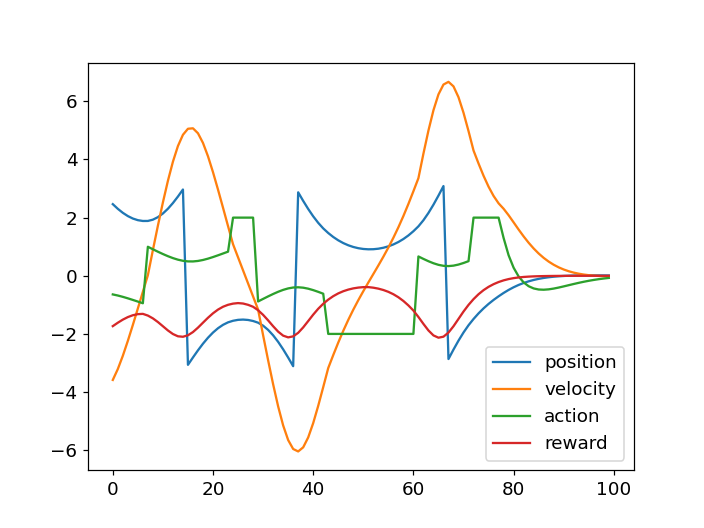

In [46]:
plt.figure()
plt.plot(states[:,0], label="position")
plt.plot(states[:,1], label="velocity")
plt.plot(actions, label="action")
plt.plot(rewards, label="reward")
plt.legend()

# Collect data

We do 500 rollouts a 100 timesteps with the black box policy. Nothing needs to be changed here.

In [47]:
for ep in range(500):
    s = env.reset()
    for t in range(100):
        a = pi.get_action(s) 
        s_new, rew, done, _ = env.step(a)
        buffer.add_transition([s,a,rew,s_new, done])
        s = s_new

In [48]:
buffer.size

50100

# Fit value function

The value function fitting class. Here, you need to fill in the blank parts

In [49]:
class ValueFunction(Feedforward):
    def __init__(self, observation_dim, hidden_sizes=[100,100]):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, output_size=1)
        self.optimizer=torch.optim.Adam(self.parameters(), lr = 0.0005, eps=0.000001)
        self.loss = torch.nn.MSELoss()
    
    def fit(self,observations, targets):
        self.train() # put model in training mode
        self.optimizer.zero_grad()
        # Forward pass
        pred = self.forward(torch.from_numpy(observations).float())
        # Compute Loss
        loss = self.loss(pred, torch.from_numpy(targets).float())
        # Backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [62]:
valuefunc = ValueFunction(observation_dim=2)

<IPython.core.display.Javascript object>


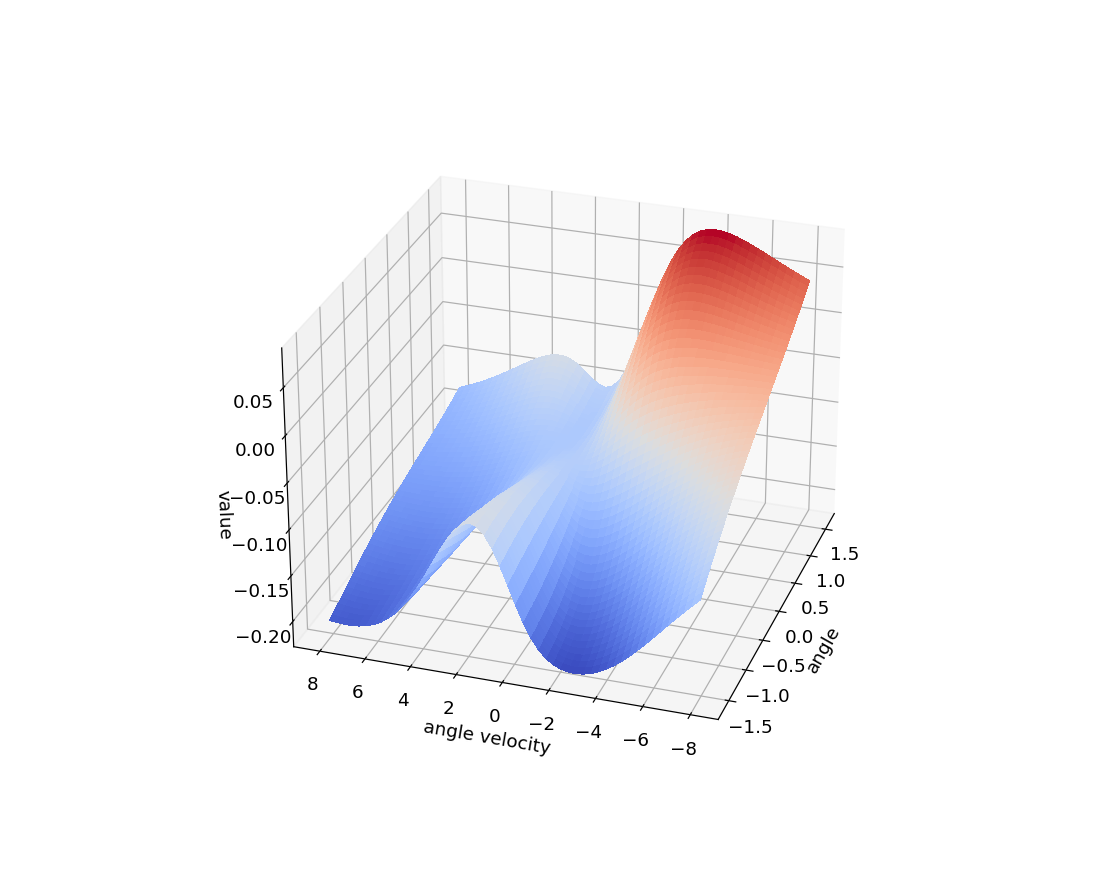

In [63]:
fig1 = plot_value_function(value_function=valuefunc)

In [64]:
fig1.savefig("value_approx_before_training.pdf", bbox_inches="tight")

Fitting routine of the value function. Fill in the blank parts.

In [65]:
plt_fit = []

In [66]:
iter_fit = 1000
gamma=0.95
for i in range(iter_fit):

    # sample from the replay buffer
    data=buffer.sample(batch=128)
    s = np.stack(data[:,0]) # s_t
    sp = np.stack(data[:,3]) # s_t+1
    rew = np.stack(data[:,2])[:,None] # rew
    
    values = valuefunc.predict(s)
    valuesp = valuefunc.predict(sp)
    # target
    td_target = rew+gamma*valuesp

    # optimize the lsq objective
    fit_loss = valuefunc.fit(s, td_target)
    plt_fit.append(fit_loss)
    

<IPython.core.display.Javascript object>


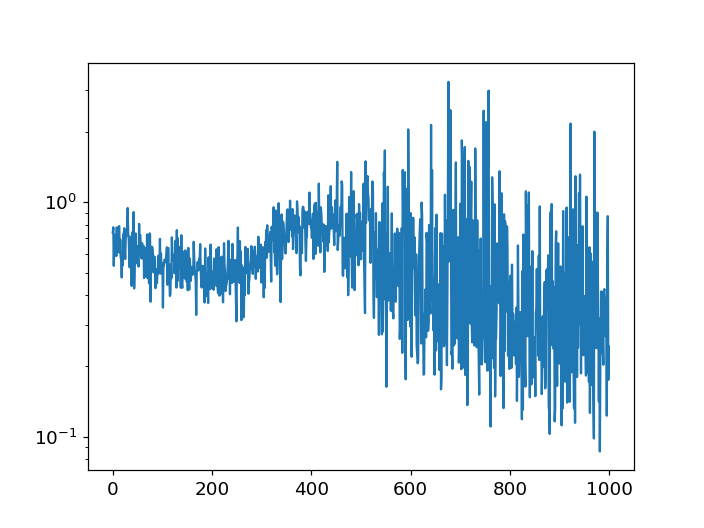

In [67]:
# plot the loss
fig_loss=plt.figure()
plt.yscale("log")
plt.plot(range(len(plt_fit)),plt_fit)

In [68]:
fig_loss.savefig("training_loss-gamma0-95.pdf", bbox_inches="tight")
#fig_loss.savefig("training_loss-gamma0-5.pdf", bbox_inches="tight")

<IPython.core.display.Javascript object>


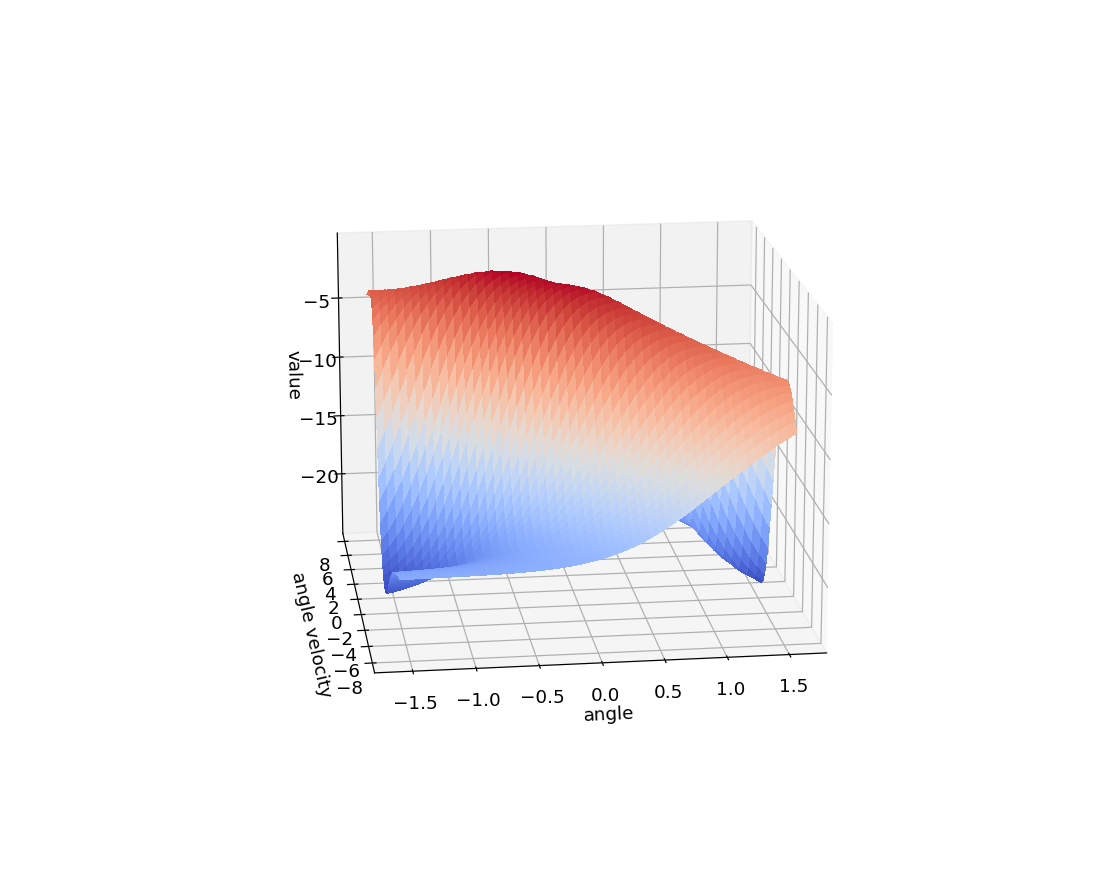

In [69]:
fig = plot_value_function(value_function=valuefunc)

In [70]:
#fig.savefig("value_approx_after_training-gamma0-5.pdf", bbox_inches="tight")
fig.savefig("value_approx_after_training-gamma0-95.pdf", bbox_inches="tight")